In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Utils
from pyshaper.utils.data_utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event


# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

2024-01-08 19:02:42.853755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Using CPU!


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Load and format images
Images should be in an (num_images, num_pixels, 3) array, where the last dimension is (intensity, x, y).

Max # of particles: 105


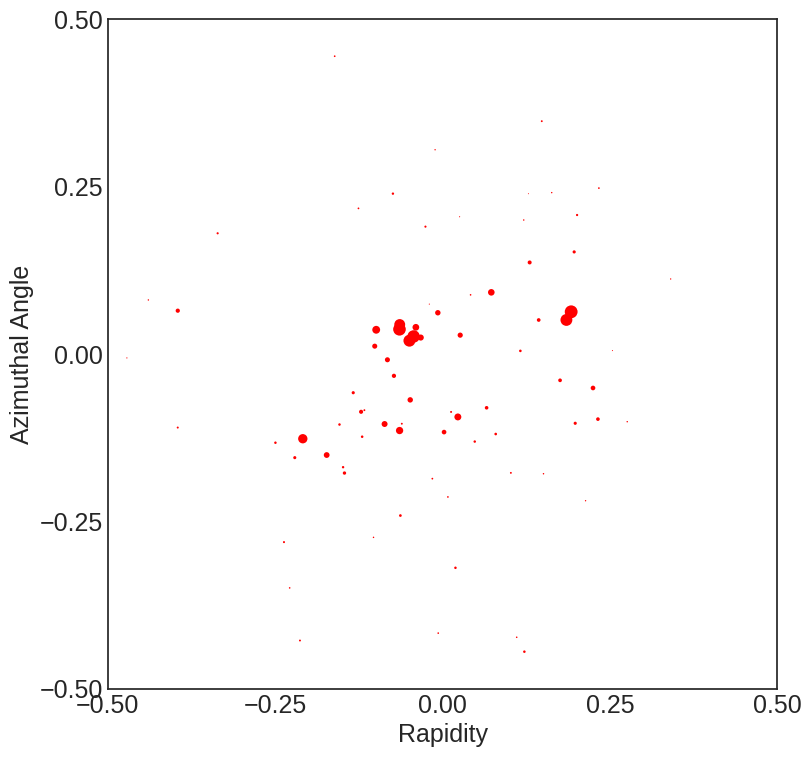

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [5]:
# Parameters
R = 0.5
beta = 1.0
N = 50
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

# Load data (NOTE: Need the `energyflow` package installed for the default dataset, or provide your own data)
dataset, _ = load_cmsopendata("~/.energyflow/", "cms", pt_lower, pt_upper, eta, quality, n = N)

# Convert to a numpy array of the form (N, pad, 3) where the last dimension is (pt, eta, phi)
temp = np.zeros((len(dataset), pad, 3))
for (i, event) in enumerate(dataset):

    num_particles = len(event[1])
    temp[i, :num_particles, 0] = event[1]
    temp[i, :num_particles, 1] = event[0][:,0]
    temp[i, :num_particles, 2] = event[0][:,1]

dataset = temp

example_event = dataset[0]
plot_event(example_event[:,1:], example_event[:,0], R, color = "red")

In [6]:
# Initialize SHAPER
shaper = Shaper({}, device)
shaper.to(device)

# Pairwise EMDS
pairwise_emds = shaper.pairwise_emds2(dataset, dataset, beta = 1.0, R = R)
print("Pairwise EMDs:\n", pairwise_emds)

# Pairwise EMDs with isometry
dataset2 = dataset.copy()
dataset2[:,:,1:] = dataset2[:,:,1:] + 1
pairwise_emds2 = shaper.pairwise_emds2(dataset, dataset2, beta = 1.0, R = R)
pairwise_emds_isometry = shaper.pairwise_emds_isometry(dataset, dataset2, beta = 1.0, R = R, lr = 0.075)

print(pairwise_emds2)
print(pairwise_emds_isometry)

torch.Size([50, 125, 2]) torch.Size([50, 125, 2])
torch.Size([50, 125]) torch.Size([50, 125])
Pairwise EMDs:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
torch.Size([50, 125, 2]) torch.Size([50, 125, 2])
torch.Size([50, 125]) torch.Size([50, 125])
Epoch 0 Mean Loss = 2.7909904956817626 Elapsed time = 1.313s Percentage done = 0.000 
Epoch 1 Mean Loss = 2.579183745384216 Elapsed time = 2.646s Percentage done = 0.000 
Epoch 2 Mean Loss = 2.367403516769409 Elapsed time = 4.100s Percentage done = 0.000 
Epoch 3 Mean Loss = 2.1556645584106446 Elapsed time = 5.570s Percentage done = 0.000 


KeyboardInterrupt: 